# MCMC parameter inference from single-molecule mRNA FISH data.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [36]:
import glob
import pickle
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
import emcee

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages 
import corner

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_mRNA_FISH/'
tmpdir = '../../tmp/'

## $\LaTeX$ macros
$\newcommand{\kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{\kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{\rm}{r _m}$
$\newcommand{\gm}{\gamma _m}$
$\newcommand{\mm}{\left\langle m \right\rangle}$


## Exploring the single-molecule mRNA FISH data from Jones et al. 2014.

In this notebook we will explore the use of the raw data from [Jones et al. 2014](http://science.sciencemag.org/content/346/6216/1533) on single molecule mRNA FISH data to make progress in determining parameters for the model.

First of all let's load the data.

In [37]:
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)
df = df[df.experiment != 'control']
df = df[df.experiment != 'Control']
df = df[df.experiment != 'Ctrl']
df.head()

,area_cells,date,experiment,spots_totals
0,321,20110920,5DL10,0
1,407,20110920,5DL10,4
2,337,20110920,5DL10,3
3,343,20110920,5DL10,2
4,320,20110920,5DL10,0


Now let's plot the raw data for the *lacUV5* promoter used in the project.

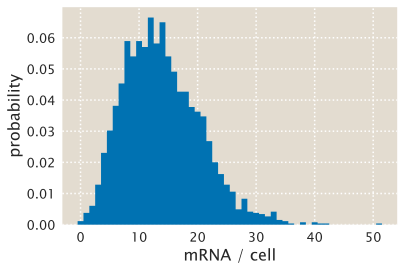

In [3]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=np.arange(0, dfUV5.spots_totals.max()),
             normed=1, histtype='stepfilled', align='left')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')

# Two-state unregulated promoter model

Given the lack of agreement between the theory and the data at the protein level we will explore the possibility of using a two-state model for the unregulated promter where it transitions from an empty promoter to occupied by RNAP.

[Peccoud & Ycart](http://www.sciencedirect.com/science/article/pii/S0040580985710271) first derived the mRNA distribution for a two-state promoter from the chemical master equation. This distribution is given by
$$
\scriptstyle
P(m) = {\Gamma\left( {\kpon \over \gm} + m \right) \over
        \Gamma (m + 1) \Gamma\left( {\kpon + \kpoff \over \gm} + m \right)}
        {\Gamma\left( {\kpon + \kpoff \over \gm} \right) \over
         \Gamma\left( {\kpon \over \gm} \right) } 
         \left( {\rm \over \gm} \right)^m
         {}_1F_1 \left( {\kpon \over \gm} + m, {\kpoff + \kpon \over \gm} + m,
                       {-\rm \over \gm} \right),
$$
where ${}_1F_1$ is the confluent hypergeometric function.

Let's define a function that computes the log probability.

In [4]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_unreg(mRNA, kp_on, kp_off, gm, rm):
    '''
    Computes the log probability lnP(m) for an unregulated promoter, 
    i.e. the probability of having m mRNA.
    
    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    gm : float.
        1 / half-life time for the mRNA.
    rm : float.
        production rate of the mRNA
    
    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)
    
    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
    + scipy.special.gammaln((kp_off + kp_on) / gm) \
    - scipy.special.gammaln(kp_on / gm) \
    + mRNA * np.log(rm / gm) \
    + np_log_hyp(kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA, -rm / gm)
    
    return lnp.astype(float)

# Bayesian parameter inference

We know that the model is homogeneous in time. What that means is that changing the time scale by a constant is equivalent to dividing all rates by the same constant. Therefore we can only hope to determine the parameter value in units of one of the rate constants. Therefore we will define $\gm \equiv 1$ and the rest of the inferred constants will be in units of this degradation rate.

Given that we want to infer three parameters, $\kpon$, $\kpoff$ and $\rm$ we can write Bayes theorem as
$$
P(\mathbf{p} \mid D) = {P(D \mid \mathbf{p}) P(\mathbf{p})
\over P(D)},
$$
where $\mathbf{p} = (\kpon, \kpoff, \rm)$, and $D$ is the data. 

For the likelihood $P(D \mid \mathbf{p})$ we will assume each datum is independent, i.e.
$$
P(D \mid \mathbf{p}) = \prod_{m \in D} P(m \mid \mathbf{p}),
$$
where each probability of obtaining $m$ mRNAs $P(m \mid \mathbf{p})$ is given by the solution of the chemical master equation as defined previously. Given our null prior knowledge about the parameters we will assume that all parameters are independent, and assign uniform distributions for strictly positive numbers, i.e.
$$
P(\mathbf{p}) = {1 \over \kpon {}^\max - \kpon {}^\min} \cdot
                {1 \over \kpoff {}^\max - \kpoff {}^\min} \cdot
                {1 \over \rm {}^\max - \rm {}^\min}.
$$

## Constraining parameters with thermodynamic picture.

In the case of this two-state promoter we know that the mean number of mRNA is given by
$$
\left\langle m \right\rangle = {\rm \over \gm} {\kpon \over \kpon + \kpoff},
$$
which is basically $\rm / \gm \times p_{\text{bound}}^{(p)}$, where $p_{\text{bound}}^{(p)}$ is the probability of the RNAP being bound at the promoter.

In the thermodynamic picture we have an equivalent result where the mean number of mRNA is given by
$$
\left\langle m \right\rangle = {\rm \over \gm} 
{{P \over N_{NS}} e^{-\beta\Delta\varepsilon_p} \over
1 + {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}},
$$
where $P$ is the number of RNAP per cell, $N_{NS}$ is the number of non-specific binding sites, $\beta\equiv {k_BT}^{-1}$ $\Delta\varepsilon_p$ is the RNAP binding energy in $k_BT$ units.

Using these two equations we can easily see that if these frameworks are to be equivalent, then it must be true that
$$
{\kpon \over \kpoff} = {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p},
$$
or
$$
\ln \left({\kpon \over \kpoff}\right) = 
-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS},
$$

Since we don't exactly know the values of all parameters in the thermodynamic picture for RNAP because we constantly use the so-called "weak promoter approximation" where we ignore them we can't have a very strong prior on this ratio. But we know that the RNAP copy number is order $P \approx 1000-3000$ RNAP/cell for our growth rate, we also know that $N_{NS} = 4.6\times 10^6$, and $-\beta\Delta\varepsilon_p \approx 5 - 7 \; k_BT$. Given these parameters we will define a *Gaussian prior* for the ratio of these two quantities of the form
$$
P(\kpon / \kpoff) \propto \exp 
\left\{ - {\left(\ln \left({\kpon \over \kpoff}\right) - 
\left(-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS} \right) \right)^2 
\over 2 \sigma^2} \right\},
$$
where $\sigma$ is the variance that will account for our uncertainty on the parameters for the RNAP.

Let's then define a function to compute the log posterior

In [5]:
def log_likelihood(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : array-like. n x 2
        data[:, 0] = unique mRNA counts
        data[:, 1] = frequency of each mRNA count
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA, counts = data[:, 0], data[:, 1]
    return np.sum(counts * log_p_m_unreg(mRNA, kp_on, kp_off, 1, rm))

def log_prior(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood(params, data)

Now that we define the functions let's sample in linear scale leaving a flexible upper bound for the parameter values.

In [21]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# generate counts of each of the mRNA values
counts = dfUV5.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data = np.vstack([counts.index.values, counts.values]).T
# Define parameter maximum values
pmax = [5000, 5000, 5000]
# Define thermodynamic constraint
p = 6 + np.log(2000 / 4.6E6)
thermo = [p, 0.3 * p]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(p)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior,\
            args=(data, pmax, thermo),\
            threads=40)

In [6]:
sample = False
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

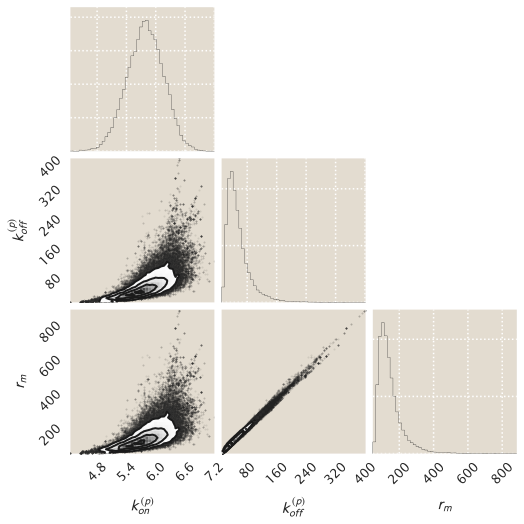

In [8]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()


# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$k^{(p)}_{on}$', r'$k^{(p)}_{off}$', r'$r_m$'])
plt.savefig(figdir + 'lacUV5_mRNA_prior_corner_plot.png', bbox_inches='tight')

In [6]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

,kp_on,kp_off,rm
0,6.049235,131.095861,315.977438
1,6.049235,131.095861,315.977438
2,6.053369,132.711373,319.550064
3,6.053369,132.711373,319.550064
4,6.053369,132.711373,319.550064


In [10]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kpon, kpoff, rm = df_mcmc.iloc[max_idx, :]

# ea range
kpon_hpd = chann_cap.hpd(df_mcmc.iloc[:, 0], 0.95)
kpoff_hpd = chann_cap.hpd(df_mcmc.iloc[:, 1], 0.95)
rm_hpd = chann_cap.hpd(df_mcmc.iloc[:, 2], 0.95)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
kp_on = {0:.1f} -{1:0.1f} +{2:0.1f}
kp_off = {3:.1f} -{4:0.1f} +{5:0.1f}
rm = {6:.1f} -{7:0.1f} +{8:0.1f}
""".format(kpon, np.abs(kpon-kpon_hpd[0]), np.abs(kpon-kpon_hpd[1]),\
           kpoff, np.abs(kpoff-kpoff_hpd[0]), np.abs(kpoff-kpoff_hpd[1]),\
           rm, np.abs(rm-rm_hpd[0]), np.abs(rm-rm_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
kp_on = 5.5 -0.4 +1.0
kp_off = 28.9 -14.3 +93.0
rm = 87.6 -32.6 +197.8



Seems that there is a very strong correlation between the $\kpoff$ and the $\rm$ parameter. But the peak seems to be at values $\ll$ 1000. Let's re-do the sampling limiting the range.

Having defined this function let's compare the theoretical prediction with the experimental data!

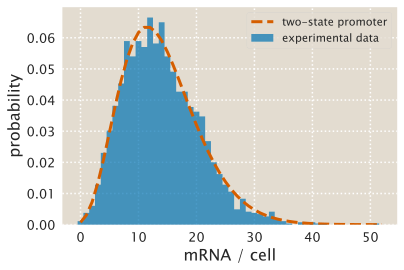

In [11]:
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())

logp_mRNA = log_p_m_unreg(bins, kpon, kpoff, 1, rm)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7, label='experimental data', align='left')

plt.plot(bins, np.exp(logp_mRNA), color='r', ls='--', lw=3,# drawstyle='steps',
         label='two-state promoter')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_fit.png')

Let's now look at the CDF.

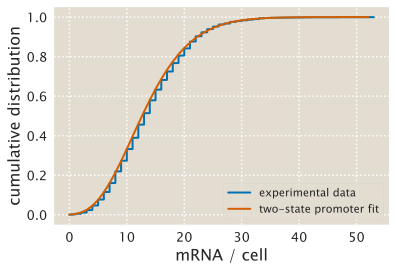

In [12]:
# Compute the empirical CDF
x, y = chann_cap.ecdf(dfUV5.spots_totals.values)
# Compute the theoretical CDF
cdf = np.cumsum(np.exp(logp_mRNA))

plt.plot(x, y, label='experimental data')
plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')
#          drawstyle='steps')

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_CDF_mcmc_fit.png')

The agreement between theory and data seems to be very promising!
That means that the parameters inferred could be potentially meaningful.

---
# Accounting for variability in the number of repressors

Jones et al. claim that the contribution to the noise in gene expression can be partially explained by the variability in gene copy number. For the locus in which our reporter construct is located (*galK*) we expect to have ≈ 1.66 copies of the gene. This implies that the cells spend **2/3** of the cell cycle with **two copies** of the promoter and the rest with a single copy.

Since for this data there is no labeling of the locus Jones et al. used area as a proxy for stage in the cell cycle. Following their procedure we will find the area threshold that sorts cells between having one or two copies of the promoter.

Let's plot the ECDF of the area and find the area value that separates the fractions of the cells.

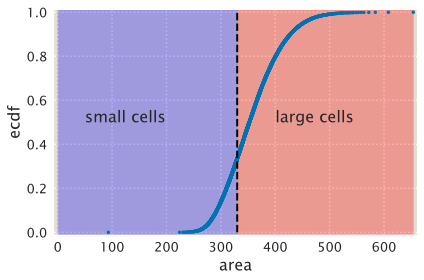

In [38]:
# Compute the area ECDF
x, y = chann_cap.ecdf(df['area_cells'])

# Find the value that is closest to 0.66
fraction = 1 / 3
idx = (np.abs(y - fraction)).argmin()
threshold = x[idx]

# Plot this ECDF
plt.plot(x[::20], y[::20], lw=0, marker='.')
# Plot vertical line next to the threshold
plt.plot([threshold, threshold], [0, 1], color='black', linestyle='--')

# Fill the area for small and large cells
plt.axvspan(0, threshold, alpha=0.3, color='blue')
plt.axvspan(threshold, max(x[::20]), alpha=0.3, color='red')

# Label as small and large cells
plt.text(50, 0.5, 'small cells', fontsize=16)
plt.text(400, 0.5, 'large cells', fontsize=16)

# Label plot
plt.xlabel('area')
plt.ylabel('ecdf')
plt.margins(0.01)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'area_division.pdf', bbox_inches='tight')

Having defined the threshold let's now re-define our likelihood such that for cells with areas smaller than the threshold it assigns a production rate $r_m$ and for cells larger than the threshold it assigns $2 r_m$.

In [47]:
def log_likelihood_double(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : 
        data[0] : array-like. n x 2
        data[0][:, 0] = unique mRNA counts for small cells
        data[0][:, 1] = frequency of each mRNA count for small cells
        data[1] : array-like. n x 2
        data[1][:, 0] = unique mRNA counts for large cells
        data[1][:, 1] = frequency of each mRNA count for large cells
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA_small, counts_small = data[0][:, 0], data[0][:, 1]
    mRNA_large, counts_large = data[1][:, 0], data[1][:, 1]
    
    return np.sum(counts_small * log_p_m_unreg(mRNA_small, kp_on, kp_off, 1, rm))\
    + np.sum(counts_large * log_p_m_unreg(mRNA_large, kp_on, kp_off, 1, 2 * rm))

def log_prior_double(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior_double(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood_double(params, data)

Let's now set the MCMC.

In [41]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# Splot DataFrame by area
dfUV5_small = dfUV5[dfUV5['area_cells'] < threshold]
# generate counts of each of the mRNA values
counts = dfUV5_small.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_small = np.vstack([counts.index.values, counts.values]).T

# Splot DataFrame by area
dfUV5_large = dfUV5[dfUV5['area_cells'] > threshold]
# generate counts of each of the mRNA values
counts = dfUV5_large.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_large = np.vstack([counts.index.values, counts.values]).T

# Join data sets
data = (data_small, data_large)


# Define parameter maximum values
pmax = [5000, 5000, 5000]
# Define thermodynamic constraint
p = 6 + np.log(2000 / 4.6E6)
thermo = [p, 0.3 * p]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(p)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior,\
            args=(data, pmax, thermo),\
            threads=40)

In [6]:
sample = True
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

---
### Incomplete...
---

# Extending fitting procedure to all promoters.

Let's extend this procedure to all of the promoters in the data-set.

First let's look at all the promoters that do not contain the string `ngmL` in their name since these are regulated promoters.

In [ ]:
# Define data frame without the experiments with induction
df_unreg = df[['ngmL' not in x for x in df.experiment]]

# Generate list of promoters by increasing mean mRNA copy number
promoters = df_unreg.groupby('experiment').mean().spots_totals.sort_values().index

# Generate a dictionary with the colors to be used in the plot
colors = sns.color_palette('Blues', n_colors=len(promoters))
color_dict = dict(zip(promoters, colors))

# Loop through different promoters
for prom in promoters:
    # Extract the promoter data
    data = df_unreg[df_unreg.experiment == prom]
    # Compute the empirical CDF
    x, y = chann_cap.ecdf(data.spots_totals.values)
    # Plot the ECDF
    plt.plot(x, y, label=prom, color=color_dict[prom])

# Label plot
plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend(fontsize=8, ncol=2)

Let's now perform the parameter estimate for this data. We will store all of the parameters into a tidy `DataFrame`.

In [ ]:
# Group data by experiment
df_group = df_unreg.groupby('experiment')

# List the variabes to be saved in the DataFrame.
var = ['experiment', 'mean_mRNA', 'n_cells',
       'kp_on', 'kp_off', 'rm', 'gm']
# Initialize Data Frame to save rates
df_param = pd.DataFrame(columns=var)

# Loop through promotres
for group, data in df_group:
    # Extract data to compute moments
    mRNA = data.spots_totals.values
    N = len(mRNA)

    # 1. Compute the moments estimators
    m_first = 1 / N * np.sum(mRNA)
    m_second = 1 / N * np.sum(mRNA * (mRNA - 1))
    m_third = 1 / N * np.sum(mRNA * (mRNA - 1) * (mRNA - 2))

    # 2. Compute moment ratios
    r1 = m_first
    r2 = m_second / m_first
    r3 = m_third / m_second

    # 3. Compute parameters
    kon = 2 * r1 * (r3 - r2) / (r1 * r2 - 2 * r1 * r3 + r2 * r3)
    koff = 2 * (r2 - r1) * (r1 - r3) * (r3 - r2) / \
               ((r1 * r2 - 2 * r1 * r3 + r2 * r3) * (r1 - 2 * r2 + r3))
    rm = (- r1 * r2 + 2 * r1 * r3 - r2 * r3) / \
             (r1 - 2 * r2 + r3)

    # 4. Compute the values knowing the gamma_m value
    gamma_m = 0.00284
    kon = kon * gamma_m
    koff = koff * gamma_m
    rm = rm * gamma_m

    # 5. Append results into data frame
    param = pd.Series([group, data.spots_totals.mean(), len(data),
                       kon, koff, rm, gamma_m], index=var)
    df_param = df_param.append(param, ignore_index=True)

In [ ]:
df_param.sort_values('mean_mRNA')

Let's plot the promoters that do not have negative parameter values and save them into a multi-page PDF document

In [ ]:
with PdfPages(figdir + 'unreg_promoter_fits_PMF.pdf') as pdf:
    for prom in promoters:
        # Extract parameters from this specific promoter
        par = df_param[df_param.experiment == prom][['kp_on', 'kp_off', 
                                                         'rm', 'gm']]
        # Check if all parameters have positive values
        if np.any(par < 0):
            continue
            
        # Convert parameters into dictionary
        par = par.to_dict(orient='records')[0]
        # Extract data from promoter
        df_plot = df[df.experiment == prom]

        # Define bins
        bins = np.arange(0, df_plot.spots_totals.max())

        # Comput theoretical PMF
        logp_mRNA = log_p_m_unreg(bins, **par)

        # Plot the histogram of the data with bins of width 1
        _ = plt.hist(df_plot.spots_totals, bins=bins, normed=1,
                     histtype='stepfilled', alpha=0.7,
                     label='experimental data', align='left')

        # Plot theoretical pdf
        plt.plot(bins, np.exp(logp_mRNA), color='r', ls='--', lw=3,
                 label='two-state promoter')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'{0:s} $\left\langle m \right\rangle$: {1:.1f}'.format(prom, 
                df_param[df_param.experiment == prom].mean_mRNA.values[0])
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

In [ ]:
with PdfPages(figdir + 'unreg_promoter_fits_CDF.pdf') as pdf:
    for prom in promoters:
        # Extract parameters from this specific promoter
        par = df_param[df_param.experiment == prom][['kp_on', 'kp_off', 
                                                         'rm', 'gm']]
        # Check if all parameters have positive values
        if np.any(par < 0):
            continue
            
        # Convert parameters into dictionary
        par = par.to_dict(orient='records')[0]
        # Extract data from promoter
        df_plot = df[df.experiment == prom]

        # Define bins
        bins = np.arange(0, df_plot.spots_totals.max())

        # Comput theoretical PMF
        logp_mRNA = log_p_m_unreg(bins, **par)
        # Compute the theoretical CDF
        cdf = np.cumsum(np.exp(logp_mRNA))
        
        # Compute the empirical CDF
        x, y = chann_cap.ecdf(df_plot.spots_totals.values)
        
        # Plot both CDFs
        plt.plot(x, y, label='experimental data')
        plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'{0:s} $\left\langle m \right\rangle$: {1:.1f}'.format(prom, 
                df_param[df_param.experiment == prom].mean_mRNA.values[0])
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()